<a href="https://colab.research.google.com/github/Murari2124/Crack-detection-using-Convolution-Neural-Network/blob/main/Copy_of_crack_detection_using_cnn_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from PIL import Image
import PIL.ImageOps    
import numpy as np
from skimage.io import imsave
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
positive_dir = Path('/content/drive/MyDrive/Positive')
negative_dir = Path('/content/drive/MyDrive/Negative')

In [ ]:
def creat_dataframe(pic_dir, label):
    filepaths = pd.Series(list(pic_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = creat_dataframe(positive_dir, label="POSITIVE")
negative_df = creat_dataframe(negative_dir, label="NEGATIVE")
print(positive_df)
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df


                                        Filepath     Label
0      /content/drive/MyDrive/Positive/09232.jpg  POSITIVE
1      /content/drive/MyDrive/Positive/09214.jpg  POSITIVE
2      /content/drive/MyDrive/Positive/09221.jpg  POSITIVE
3      /content/drive/MyDrive/Positive/09224.jpg  POSITIVE
4      /content/drive/MyDrive/Positive/09217.jpg  POSITIVE
...                                          ...       ...
10217  /content/drive/MyDrive/Positive/00237.jpg  POSITIVE
10218  /content/drive/MyDrive/Positive/00219.jpg  POSITIVE
10219  /content/drive/MyDrive/Positive/00222.jpg  POSITIVE
10220  /content/drive/MyDrive/Positive/00224.jpg  POSITIVE
10221  /content/drive/MyDrive/Positive/00218.jpg  POSITIVE

[10222 rows x 2 columns]


Filepath     Label
0      /content/drive/MyDrive/Positive/03168.jpg  POSITIVE
1      /content/drive/MyDrive/Positive/08331.jpg  POSITIVE
2      /content/drive/MyDrive/Negative/09143.jpg  NEGATIVE
3      /content/drive/MyDrive/Negative/06616.jpg  NEGATIVE
4      /content/drive/MyDrive/Negative/09363.jpg  NEGATIVE
...                                          ...       ...
20297  /content/drive/MyDrive/Negative/09699.jpg  NEGATIVE
20298  /content/drive/MyDrive/Negative/02122.jpg  NEGATIVE
20299  /content/drive/MyDrive/Positive/04408.jpg  POSITIVE
20300  /content/drive/MyDrive/Negative/08941.jpg  NEGATIVE
20301  /content/drive/MyDrive/Positive/09459.jpg  POSITIVE

[20302 rows x 2 columns]

In [ ]:
train_df, test_df = train_test_split(
    all_df,
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
     rotation_range = 10,
    width_shift_range=0.1,
    horizontal_flip = True,
    height_shift_range=0.1,
    fill_mode = 'nearest'
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 11369 validated image filenames belonging to 2 classes.
Found 2842 validated image filenames belonging to 2 classes.
Found 6091 validated image filenames belonging to 2 classes.


In [ ]:
inputs = tf.keras.Input(shape=(120, 120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496 

In [ ]:
btpdmodel = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
356/356 [==============================] - 11263s 32s/step - loss: 0.3492 - accuracy: 0.8456 - val_loss: 0.0883 - val_accuracy: 0.9673
Epoch 2/100
356/356 [==============================] - 77s 218ms/step - loss: 0.1191 - accuracy: 0.9638 - val_loss: 0.0756 - val_accuracy: 0.9729
Epoch 3/100
356/356 [==============================] - 79s 221ms/step - loss: 0.0759 - accuracy: 0.9776 - val_loss: 0.0479 - val_accuracy: 0.9828
Epoch 4/100
356/356 [==============================] - 79s 223ms/step - loss: 0.0803 - accuracy: 0.9778 - val_loss: 0.0465 - val_accuracy: 0.9842
Epoch 5/100
356/356 [==============================] - 79s 223ms/step - loss: 0.0710 - accuracy: 0.9787 - val_loss: 0.0470 - val_accuracy: 0.9866
Epoch 6/100
356/356 [==============================] - 78s 219ms/step - loss: 0.0553 - accuracy: 0.9833 - val_loss: 0.0369 - val_accuracy: 0.9873
Epoch 7/100
356/356 [==============================] - 78s 218ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.0458 

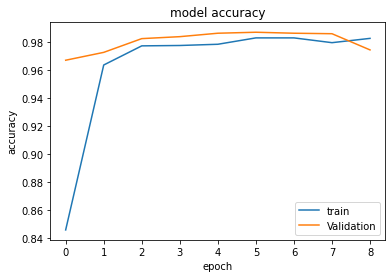

In [ ]:
plt.plot(btpdmodel.history['accuracy'])
plt.plot(btpdmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
model.save('/content/drive/MyDrive/internship') 

In [ ]:
evaluate_model(model, test_data)

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(btpdmodel.history['loss'], label='Training Loss')
plt.plot(btpdmodel.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(btpdmodel.history['accuracy'], label='Training Accuracy')
plt.plot(btpdmodel.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import os
import cv2
import PIL
from tensorflow.keras.preprocessing import image

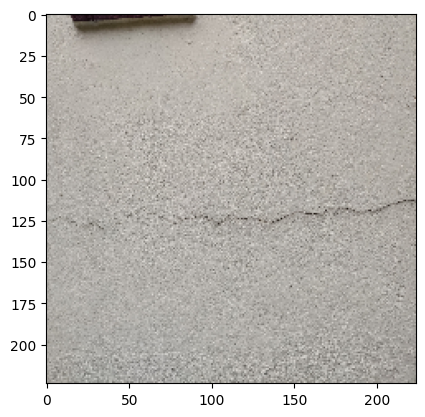

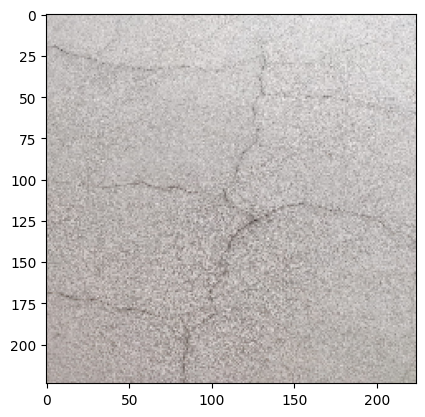

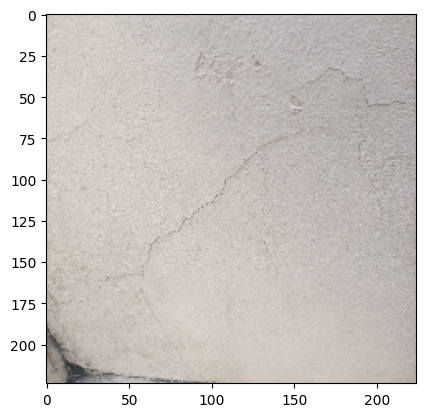

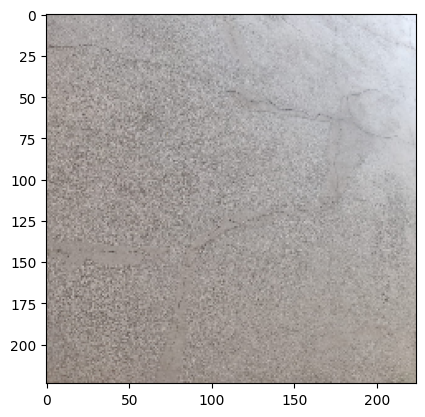

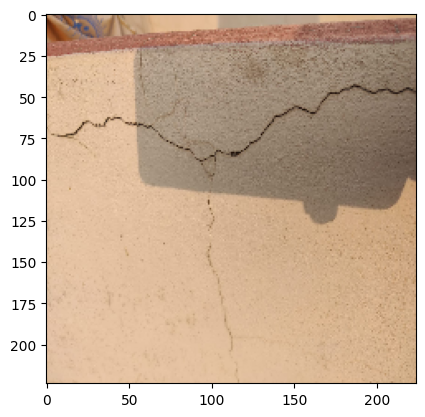

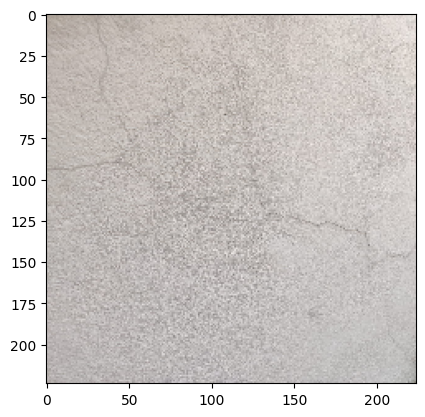

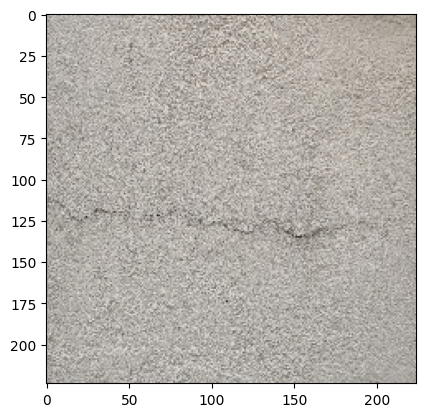

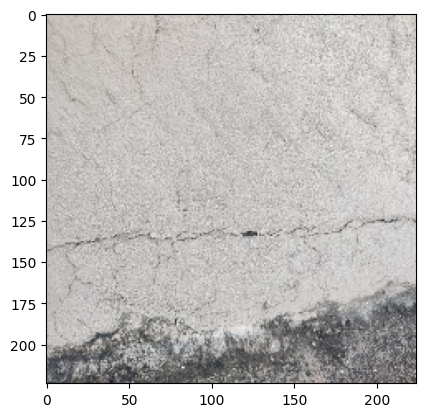

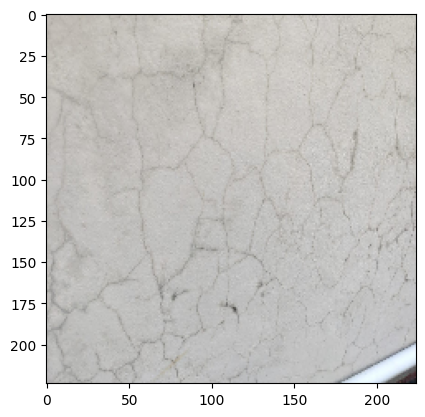

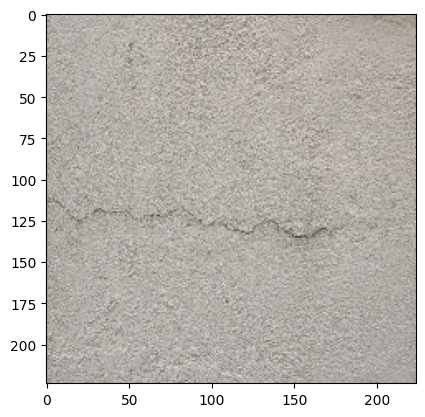

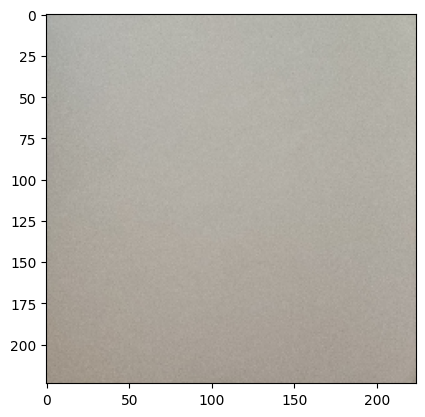

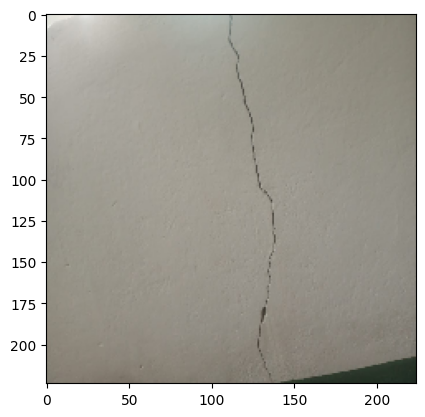

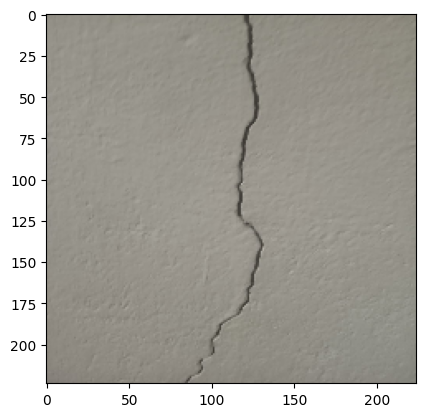

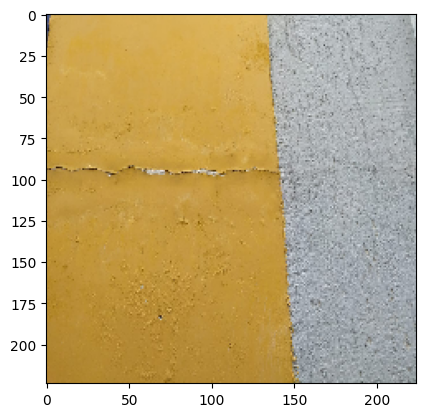

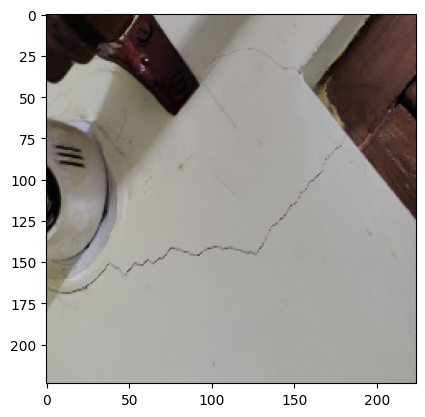

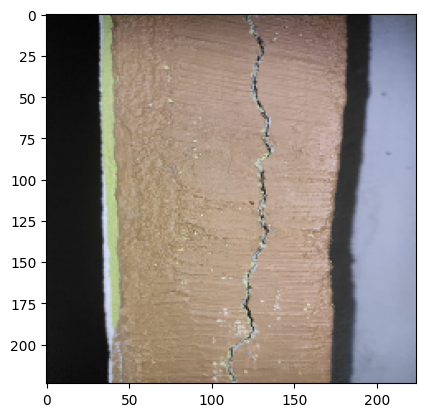

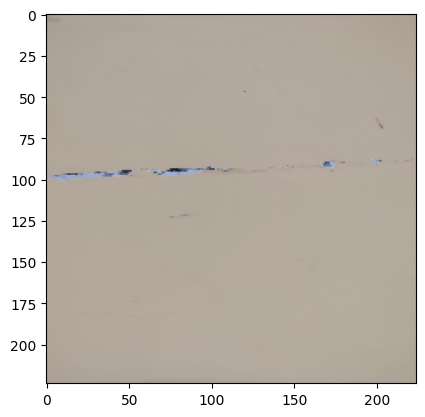

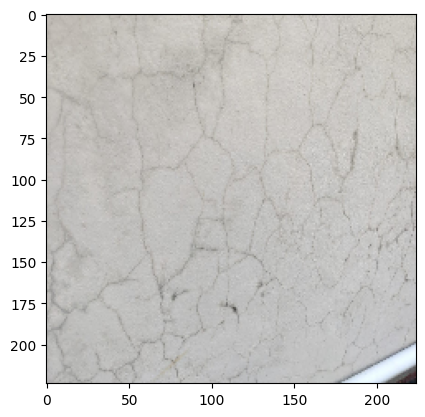

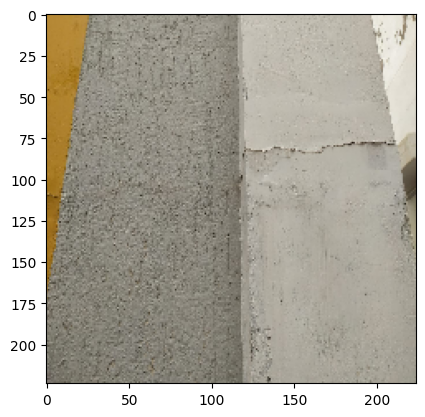

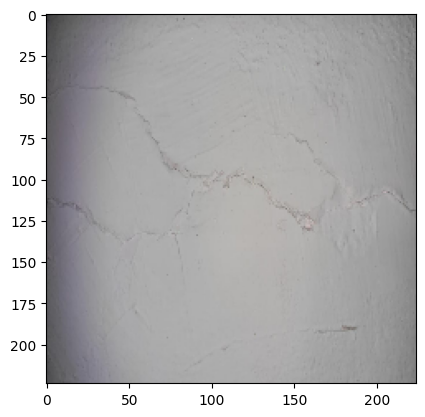

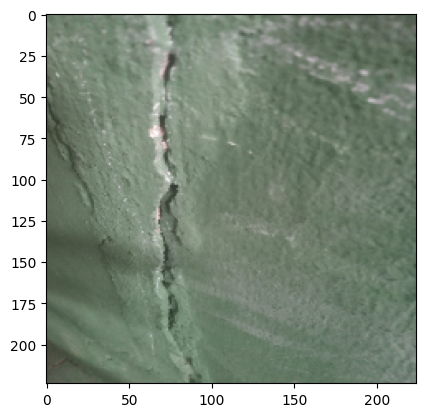

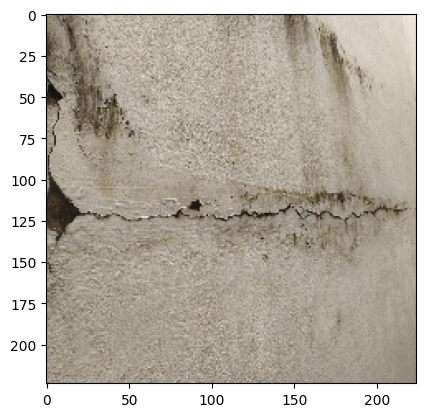

UnidentifiedImageError: ignored

In [ ]:
dir_list=os.listdir('/content/drive/MyDrive/Example_cracked')
for i in dir_list:
  path1='/content/drive/MyDrive/Example_cracked'+'/'+i
  img = image.load_img(path1, target_size=(224, 224))
  plt.imshow(img)
  plt.show()

In [ ]:
example_dir=Path('/content/drive/MyDrive/Example_cracked')

In [ ]:
example_df=creat_dataframe(example_dir,'EXAMPLE')
example_df

Filepath    Label
0   /content/drive/MyDrive/Example_cracked/IMG_202...  EXAMPLE
1   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
2   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
3   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
4   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
5   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
6   /content/drive/MyDrive/Example_cracked/IMG_202...  EXAMPLE
7   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
8   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
9   /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
10  /content/drive/MyDrive/Example_cracked/IMG_202...  EXAMPLE
11  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
12  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
13  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
14  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
15  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
16  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
17  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
18  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
19  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
20  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE
21  /content/drive/MyDrive/Example_cracked/IMG-202...  EXAMPLE

In [ ]:
example_data=test_gen.flow_from_dataframe(
dataframe=example_df,
x_col="Filepath",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
)

NameError: ignored

In [ ]:
arr=(model.predict(example_data)>=0.5).astype(np.int)
k=0
for i in dir_list:
  path1='/content/drive/MyDrive/Example_cracked'+'/'+i
  img = image.load_img(path1, target_size=(224, 224))
  plt.imshow(img)
  plt.show()
  if(arr[k]==1):
    print("The image has crack")
    Image = cv2.imread(path1)
    Image2 = np.array(Image, copy=True)
    red_px = np.asarray([255, 0, 0])
    black_px = np.asarray([0  , 0  , 0  ])
    (row, col, _) = Image.shape
    for r in range(0,row):
      for c in range(0,col):
          px = Image[r][c]
          if(px[0]<120 and px[1]<120 and px[2]<120):
            Image2[r][c] = red_px
          else:
           Image2[r][c] = black_px
    plt.imshow(Image2, interpolation='nearest') 
    plt.show()
  else:
    print("The image does not have the crack")
  k=k+1

In [ ]:
from google.colab import files


# Specify export directory and use tensorflow to save your_model
export_dir = './saved_model'
tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
files.download(export_dir + '/saved_model.pb')

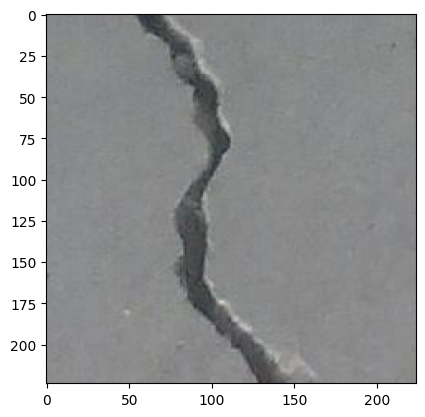

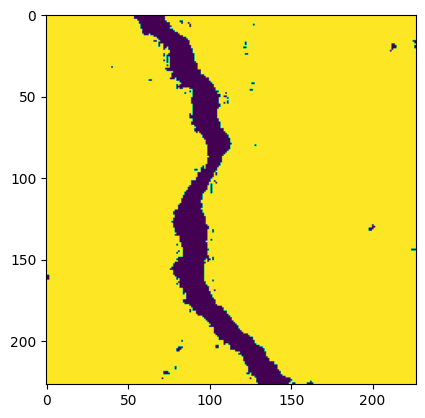

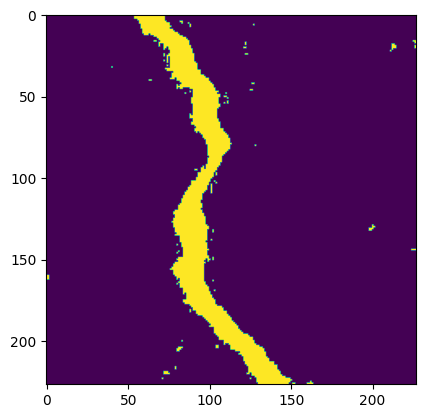

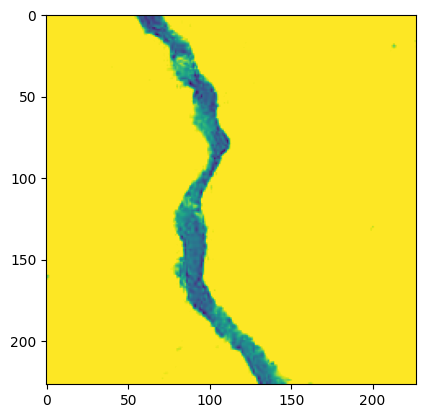

(227, 227)
127


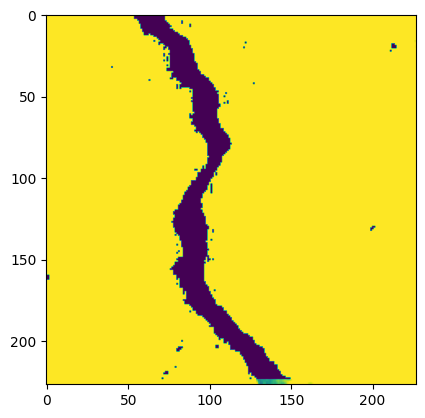

The crack/total area percentage is:  7.497608418367347


In [ ]:

# Loading the image named test.jpg
img = cv2.imread(r"/content/drive/MyDrive/Positive/00003.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img1 = image.load_img("/content/drive/MyDrive/Positive/00003.jpg", target_size=(224, 224))
plt.imshow(img1)
plt.show()

ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
 
# Displaying the output image
plt.imshow(thresh1)
plt.show()
ret, thresh2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh2)
plt.show()
ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
plt.imshow(thresh3)
plt.show()
c=0
n=0
print(thresh3.shape)
print(thresh3[0][0])
for i in range(0,224):
  for j in range(0,224):
    if(thresh1[i][j]>100):
      n=n+1
    else:
      c=c+1
plt.imshow(thresh3)
plt.show()
cbn = c*100/(c+n)
print('The crack/total area percentage is: ',cbn)

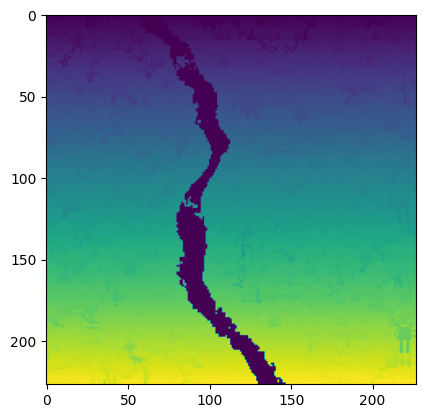

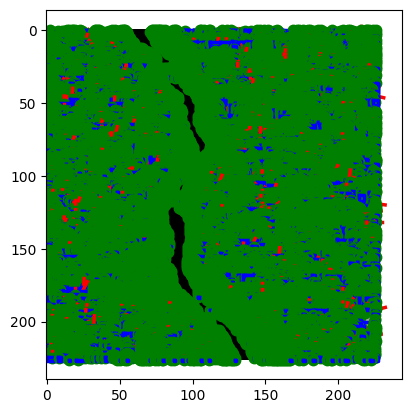

In [ ]:
from skimage.measure import label, regionprops_table
import pandas as pd
import math
from skimage.measure import regionprops
# connected pixels of same label get assigned a value
label_img = label(thresh3)
plt.imshow(label_img)
plt.show()
regions=regionprops(label_img)
props = regionprops_table(label_img, properties=('centroid',
                                             'bbox',
                                             'orientation',
                                             'major_axis_length',
                                             'minor_axis_length'))

df = pd.DataFrame(props)
df
fix, ax = plt.subplots()

ax.imshow(thresh3,cmap=plt.cm.gray)
for props in regions:
    y0, x0 = props.centroid
    
    
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)


    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

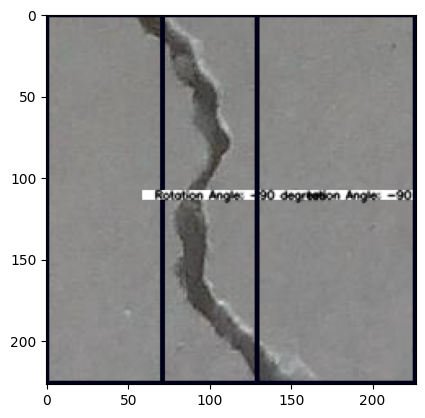

True

In [ ]:
img = cv2.imread(r"/content/drive/MyDrive/Positive/00003.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
# Convert image to binary
_, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
 
# Find all the contours in the thresholded image
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):
 
  # Calculate the area of each contour
  area = cv2.contourArea(c)
 
  # Ignore contours that are too small or too large
  if area < 3700 or 100000 < area:
    continue
 
  # cv.minAreaRect returns:
  # (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(c)
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
 
  # Retrieve the key parameters of the rotated bounding box
  center = (int(rect[0][0]),int(rect[0][1])) 
  width = int(rect[1][0])
  height = int(rect[1][1])
  angle = int(rect[2])
 
     
  if width < height:
    angle = 90 - angle
  else:
    angle = -angle
         
  label = "  Rotation Angle: " + str(angle) + " degrees"
  textbox = cv2.rectangle(img, (center[0]-5, center[1]-5), 
    (center[0] + 95, center[1] + 0), (255,255,255), -1)
  cv2.putText(img, label, (center[0]-5, center[1]), 
    cv2.FONT_HERSHEY_SIMPLEX, 0.23, (0,0,0), 1, cv2.LINE_AA)
  cv2.drawContours(img,[box],0,(0,0,25),2)
 
plt.imshow(img)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()
  
# Save the output image to the current directory
cv2.imwrite("min_area_rec_output.jpg", img)

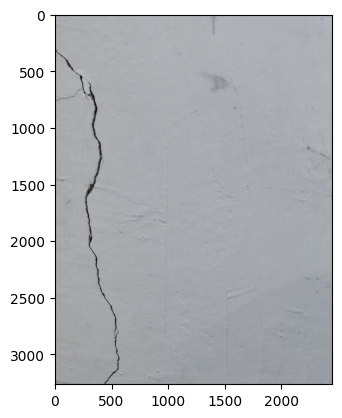

1/1 [==============================] - 0s 34ms/step


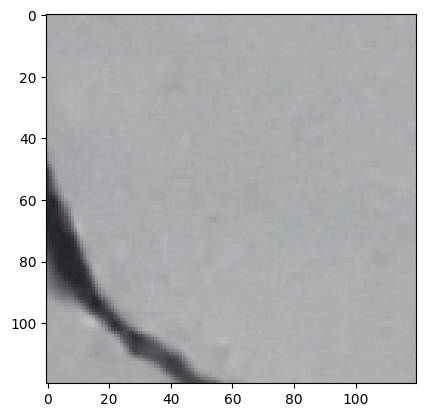

None
1/1 [==============================] - 0s 29ms/step


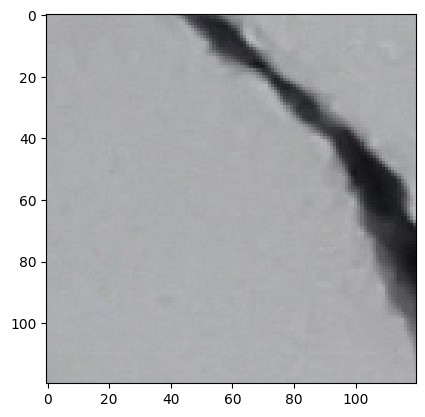

None
1/1 [==============================] - 0s 26ms/step


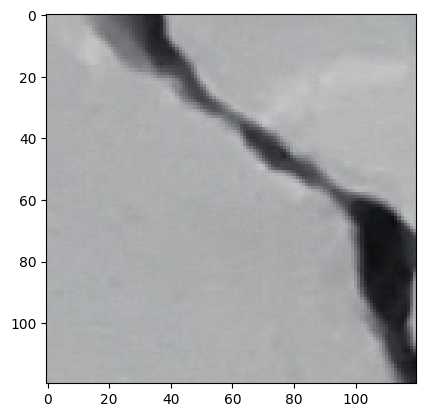

None


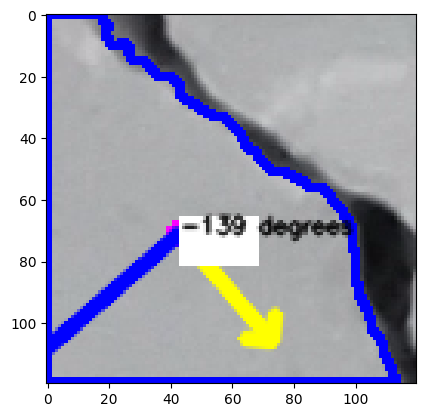

In [ ]:
import cv2 as cv
from math import atan2, cos, sin, sqrt, pi
import numpy as np
 
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)
 
  ## [visualization1]
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
 
  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
  ## [visualization1]
 
def getOrientation(pts, img):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
 
  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
 
  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]
 
  ## [visualization]
  # Draw the principal components
  cv.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
  ## [visualization]
 
  # Label with the rotation angle
  label =  str(-int(np.rad2deg(angle)) - 90) + " degrees"
  textbox = cv.rectangle(img, (cntr[0], cntr[1]-5), (cntr[0] + 25, cntr[1] + 10), (255,255,255), -1)
  cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.25, (0,0,0), 1, cv.LINE_AA)
 
  return angle
 

def check(img):
  # Was the image there?
  if img is None:
    print("Error: File not found")
    exit(0)
  plt.imshow(img)
  plt.show()
  
  # Convert image to grayscale
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  
  # Convert image to binary
  _, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
  
  # Find all the contours in the thresholded image
  contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
  
  for i, c in enumerate(contours):
  
    # Calculate the area of each contour
    area = cv.contourArea(c)
  
    # Ignore contours that are too small or too large
    if area < 3700 or 100000 < area:
      continue
  
    # Draw each contour only for visualisation purposes
    cv.drawContours(img, contours, i, (0, 0, 255), 2)
  
    # Find the orientation of each shape
    getOrientation(c, img)
  
  plt.imshow(img)
  plt.show

# Load the image
img1 = cv.imread(r"/content/IMG_20230430_210438.jpg")
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/internship')


plt.imshow(img1)
plt.show()
m,n,v=img1.shape
h=0
for i in range(0,m,120):
    for j in range(0,n,120):
        a = img1[i:i + 120, j:j + 120]
        b = np.expand_dims(a, axis=0)
        if(model.predict(b)>=0.5):
            k=check(img1[i:i+120,j:j+120])
            print(k)
            h+=1
            break
    if(h==3):
      break

1200 1200
1/1 [==============================] - 0s 25ms/step


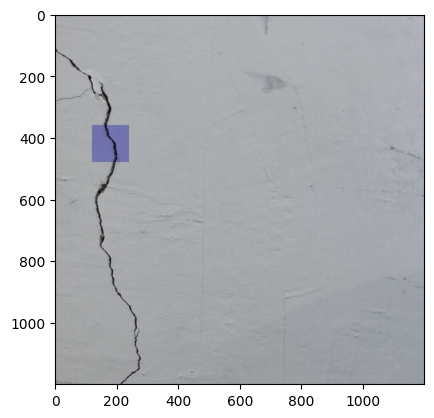

In [ ]:
import cv2 as cv
img1 = cv.imread(r"/content/IMG_20230430_210438.jpg")
img1 = cv.resize(img1,(1200,1200))
m,n,v=img1.shape
print(m,n)
h=0
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/internship')
for j in range(0,m,120):
    for k in range(0,n,120):
      a=img1[j:j+120,k:k+120]
      a = np.expand_dims(a, axis=0)
      if(h<3 and model.predict(a)>=0.5):
          h=h+1
          if(h==3):
            img1[j:j + 120, k:k + 120, 0] =img1[j:j + 120, k:k + 120, 0] /1.5
            img1[j:j + 120, k:k + 120, 1] =img1[j:j + 120, k:k + 120, 1] /1.5
plt.imshow(img1)
plt.show()

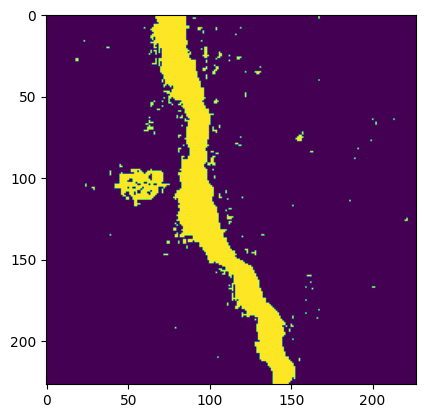

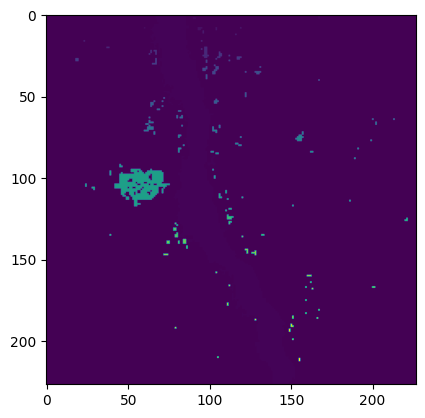

In [ ]:
from skimage.measure import label, regionprops_table
cleared = cv2.imread(r"/content/drive/MyDrive/Positive/00001.jpg")
cleared = cv2.cvtColor(cleared, cv2.COLOR_BGR2GRAY)
ret, cleared = cv2.threshold(cleared, 127, 255, cv2.THRESH_BINARY)
for i in range(0,227):
  for j in range(0,227):
    if(cleared[i][j]==255):
      cleared[i][j]=0
    else:
      cleared[i][j]=255
plt.imshow(cleared)
plt.show()
label_image = label(cleared)
plt.imshow(label_image)
plt.show()

In [ ]:

from skimage.measure import label, regionprops_table
img = cv2.imread(r"/content/drive/MyDrive/Positive/00001.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
label_img=label(img)


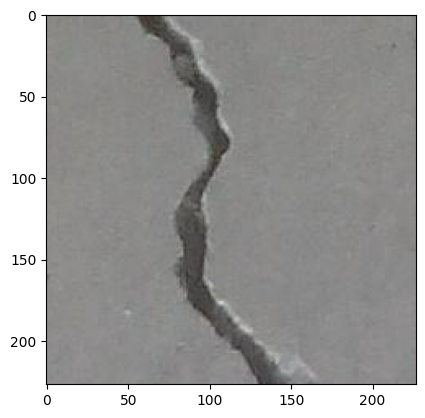

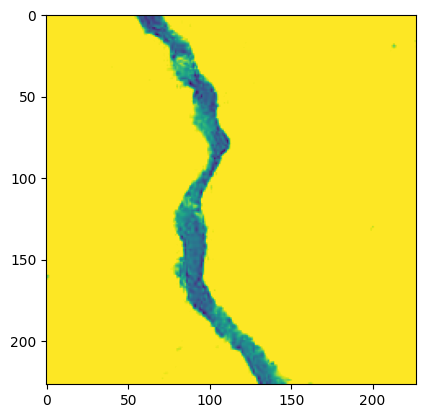

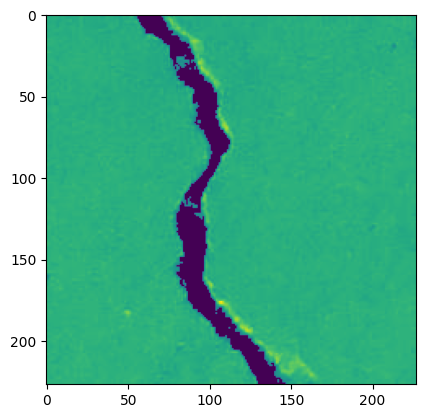

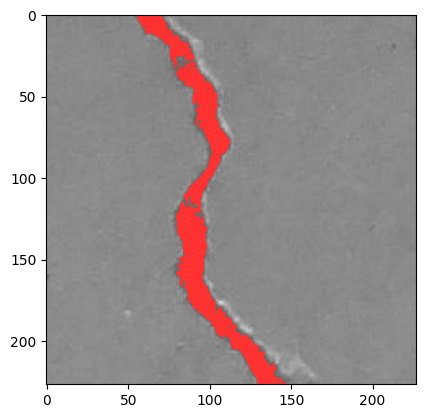

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

import numpy as np

#image loading
image = cv2.imread(r"/content/drive/MyDrive/Positive/00003.jpg")
#plot image
plt.imshow(image)
plt.show()
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
#plot threshold image
plt.imshow(thresh3)
plt.show()
for i in range(0,227):
  for j in range(0,227):
    if(thresh3[i][j]>=100):
      thresh3[i][j]=img1[i][j] #convert threshold pixel to original image pixel
    else:
      thresh3[i][j]=0
thresh3[0][0]=0       #referece point
plt.imshow(thresh3)
plt.show()
image_rgb = cv2.cvtColor(thresh3, cv2.COLOR_GRAY2RGB)
red_px = np.asarray([255,50,50])
black_px = np.asarray([0  , 0  , 0  ])
(row, col, _) = image_rgb.shape
pxstd1=image_rgb[0][0][0]
pxstd2=image_rgb[0][0][1]
pxstd3=image_rgb[0][0][2]
for r in range(0,row):
  for c in range(0,col):
    if(image_rgb[r][c][0]==pxstd1 or image_rgb[r][c][1]==pxstd2 or image_rgb[r][c][2]==pxstd3):   
      image_rgb[r][c] = red_px     #converted cracked pixel to red colour pixel
plt.imshow(image_rgb)
plt.show()

